<img src="C:\Users\gguevara\OneDrive - Universidad EARTH\python-analysis/logo.png">

# Plantilla para el análisis de Golpe de Ariete en diseño de tuberías 

## Jupypter Notebook by Python 3.9.4

EL presente trabajo, a partir de una seríe de datos de entrada como línea piezométrica y diámetro propuesto de tubería para un caudal de flujo definido, nos permite modelar diferentes escenario de GOLPE DE ARIETE, a partir de simulaciones en las velocidades de cierre de las válvulas  

## Preparado por:
### Prof. Gregory Guevara Laboratorio de Fertirriego Univeridad Earth, Mayo 2021

### Basado en: 
Guevara-Rodríguez, G; Vargas-Obando, A;Quesada-Chanto, J. I. Prevención del golpe de ariete mediante el control del tiempo de cierre, al usar válvulas hidráulicas automatizadas. Tecnología en Marcha. Vol. 34-1. EneroMarzo 2021. Pág 143-154. https://revistas.tec.ac.cr/index.php/tec_marcha/article/view/4821 



### Importación de Paquetes a usarse

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from math import pi

### Apertura de datos apartir de un perfil topográfico y datos de la tubería 


In [4]:
#open data frame de excel 
df = pd.read_excel(r'C:\Users\gguevara\OneDrive - Universidad EARTH\python-analysis\Golpe de ariete\perfil.xlsx')
df= df.dropna() # me permite borrar valores vacios 

#Otros variables a declarar
dia=float(108.00) # diametro interno de la tubería en mm
Espesor= float(7.02) # espesor de la tubería 
ee=3*10**8
CDT= float(40.00)  # Carga dinámica total 
C=float(150) # C para HAZEN WILLIAMS

print (df)


    punto   elevacion  long_acum  caudal
0  inicio         835          0      50
1        1        835         70      50
2        2        825        140      50
3        3        825        210      50
4        4        815        280      50
5        5        815        350      50
6        6        805        420      50
7        7        805        490      50
8        8        800        560      50


### A continuación procedemos a cálcular la línea piezométrica del sistema bajo condiciones normales de operación 

In [6]:

# determinación de la columna "longitud parcial"
df["long_par"]=df["long_acum"]-df["long_acum"].shift(+1)
df= df.fillna(0) # me permite los na convertir en 0

#Determinación de la columna "pérdidas por fricción" 
def hf (fila):
    hf=1.131*10**9*(fila["caudal"]/C)**1.852*fila["long_par"]*dia**-4.872
    return hf
df["hf"]=df.apply(hf,axis=1)

# determino la columna de perdidas acumuladas 
df["hf_acum"]= df['hf'].cumsum()

#cálculo de la presión en el tubo
elev_inicial=(df.loc[0, 'elevacion'])
df["P_punto"]=CDT-df['hf_acum']+elev_inicial-df['elevacion']

#rutina para el cálculo de linea piezometrica 
df["L_piezometrica"]=df["P_punto"]+df["elevacion"]

#velocidad en m/s
Q=(df.loc[0, 'caudal'])
vel=Q/(pi*(dia/1000)**2/4)/3600

#distancia total del sistema
distancia=df['long_par'].sum()

#datos de salida 
print("*********************************")
print ("la velocidad en es sistema es de " + str(vel.round(2))+ " m/s")
print("")
print (df.round(2))



*********************************
la velocidad en es sistema es de 1.52 m/s

    punto   elevacion  long_acum  caudal  long_par    hf  hf_acum  P_punto  \
0  inicio         835          0      50       0.0  0.00     0.00    40.00   
1        1        835         70      50      70.0  1.28     1.28    38.72   
2        2        825        140      50      70.0  1.28     2.57    47.43   
3        3        825        210      50      70.0  1.28     3.85    46.15   
4        4        815        280      50      70.0  1.28     5.13    54.87   
5        5        815        350      50      70.0  1.28     6.41    53.59   
6        6        805        420      50      70.0  1.28     7.70    62.30   
7        7        805        490      50      70.0  1.28     8.98    61.02   
8        8        800        560      50      70.0  1.28    10.26    64.74   

   L_piezometrica  
0          875.00  
1          873.72  
2          872.43  
3          871.15  
4          869.87  
5          868.59  
6 

### Realizamos el gráfico del perfil hidráulico del sistema 

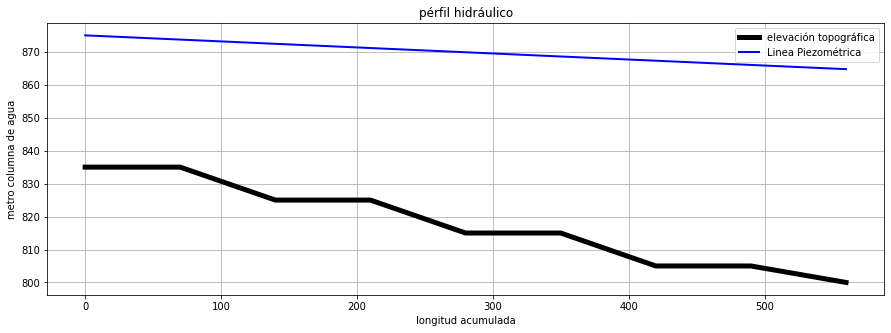

In [8]:
#grafico del perfil hidráulico 

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.plot(df["long_acum"],df["elevacion"], color='k',linewidth=5,
                label='elevación topográfica')
rects2 = ax.plot(df["long_acum"],df["L_piezometrica"], color='b',linewidth=2,
                label='Linea Piezométrica')
ax.set_xlabel('longitud acumulada')
ax.set_ylabel('metro columna de agua')
ax.set_title('pérfil hidráulico')
ax.grid(True)
ax.legend()
plt.show()
 

### tiempo de cierre de válvula

In [10]:
t_valvula=float(2.00) # esta es una variable que declaramos y es el tiempo que dura el cierre de la válvula aguas abajo

### Cálculos para modelar el tipo de golpe que tendremos. 

In [12]:

#calculos de Celeridad 
kcel=10**10/ee
celeridad=9900/(48.3+kcel*dia/Espesor)**0.5
print("###################")
print ("Constante K de celeridad = " + str(kcel))
print("el valor de celeridad = " +str(celeridad))

#Cálculo del tiempo de la onda que va desde la válvula hacia el origen
t_onda= 2*distancia/celeridad
print("###################")
print("el valor de viaje de la onda es de " +str(t_onda)+ " segundos")

#Determinación del tipo de cierre (rápido o lento )
if t_valvula>t_onda:
    cierre=0
    delta_h= 2*distancia*vel/9.81/t_valvula #formula de sobrepresión MICHAUD
    print ("como la vel_valvula > Vel_onda ==> el tipo de cierre es Lento")
    print ("el valor de la sobrepresión es de " + str(delta_h) + " mca")
else:
    cierre=1
    delta_h=celeridad*vel/9.81  #formula de sopresión según Allieve
    print ("como la vel_valvula < Vel_onda ==>el tipo de cierre es Rápido") 
    print ("el valor de la sobrepresión es de " + str(delta_h) + " mca")


###################
Constante K de celeridad = 33.333333333333336
el valor de celeridad = 417.93344023804514
###################
el valor de viaje de la onda es de 2.6798525606423698 segundos
como la vel_valvula < Vel_onda ==>el tipo de cierre es Rápido
el valor de la sobrepresión es de 64.59043742524491 mca


### Cálculo de longitud en que se manifestará la sobre presión

In [14]:
# Calculos de Longitudes Sobresión decreciente 
long_deltaH_decreciente=celeridad*t_valvula/2
print("La longitud de sobrepresión decreciente= "+ str(long_deltaH_decreciente)+" m")
long_deltaH_constante=float(0.00)
if long_deltaH_decreciente>distancia:
    print("La longitud de sobrepresión constante= "+ str(long_deltaH_constante)+" m")
else:
    long_deltaH_constante=distancia-long_deltaH_decreciente
    print("La longitud de sobrepresión constante= "+ str(long_deltaH_constante)+" m")



La longitud de sobrepresión decreciente= 417.93344023804514 m
La longitud de sobrepresión constante= 142.06655976195486 m


### A continuación vamos a integrar  los valores de la sobrepresión y su posición en lo largo del perfil del terreno
Los datos quedan tabulados 

In [16]:
# calculo de la sobrepresión máxima segun michaud (dato teoríco)
df['L_Michaud']=df['L_piezometrica']+2*df['long_acum']*vel/9.81/t_valvula

# determinación de la sobrepresión esperada (linea piezométrica)
a=list(range(0,len(df)))

if distancia<long_deltaH_decreciente:
    df["LP_deltaH"]=df['L_Michaud']
else:
    for x in a:
        long=df.loc[x,'long_acum']
        if long>long_deltaH_decreciente:
            df.at[x,"LP_deltaH"]=df.loc[0,'L_piezometrica']+(vel*celeridad/9.81)
        else:
            df.at[x,"LP_deltaH"]=df.loc[x,'L_Michaud']
print (df.round(2))




    punto   elevacion  long_acum  caudal  long_par    hf  hf_acum  P_punto  \
0  inicio         835          0      50       0.0  0.00     0.00    40.00   
1        1        835         70      50      70.0  1.28     1.28    38.72   
2        2        825        140      50      70.0  1.28     2.57    47.43   
3        3        825        210      50      70.0  1.28     3.85    46.15   
4        4        815        280      50      70.0  1.28     5.13    54.87   
5        5        815        350      50      70.0  1.28     6.41    53.59   
6        6        805        420      50      70.0  1.28     7.70    62.30   
7        7        805        490      50      70.0  1.28     8.98    61.02   
8        8        800        560      50      70.0  1.28    10.26    64.74   

   L_piezometrica  L_Michaud  LP_deltaH  
0          875.00     875.00     875.00  
1          873.72     884.54     884.54  
2          872.43     894.07     894.07  
3          871.15     903.61     903.61  
4        

### Gráfico que ilustra el efecto del tiempo de cierre de la válvula en la magnitud y ubicación del golpe de ariete

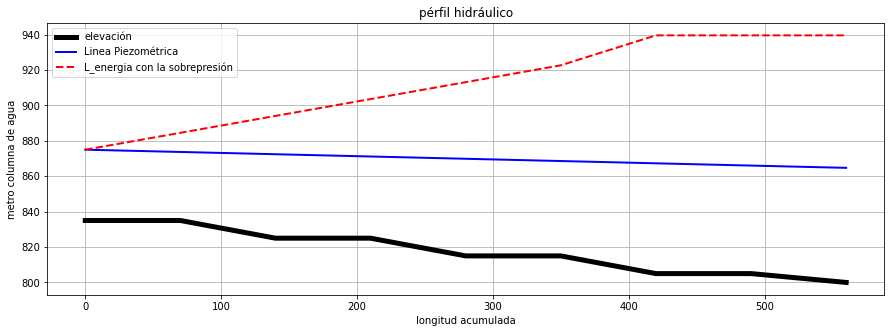

Para un tiempo de cierre de 2.0 s, la máxima sobrepresión en el tubo es de 74.85 mca


In [18]:
#grafico del perfil hidráulico 

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.plot(df["long_acum"],df["elevacion"], color='k',linewidth=5,
                label='elevación')
rects2 = ax.plot(df["long_acum"],df["L_piezometrica"], color='b',linewidth=2,
                label='Linea Piezométrica')
rects3 = ax.plot(df["long_acum"],df["LP_deltaH"], color='r',linewidth=2,linestyle='--',
                label='L_energia con la sobrepresión')    
ax.set_xlabel('longitud acumulada')
ax.set_ylabel('metro columna de agua')
ax.set_title('pérfil hidráulico')
ax.grid(True)
ax.legend()
plt.show()


df["P_tubo_Golpe"]=df['LP_deltaH']-df['L_piezometrica']
pmax1=df['P_tubo_Golpe'].max()
print ("Para un tiempo de cierre de "+str(t_valvula)+" s, la máxima sobrepresión en el tubo es de "+str(pmax1.round(2))+" mca")


### automáticamente generamos un escenario con un tiempo de cierre del doble del ingresado 

##############################
Para un tiempo de cierre de 2.0 s, la máxima sobrepresión en el tubo es de 74.85 mca
Para un tiempo de cierre de 4.0 s, la máxima sobrepresión en el tubo es de 43.27 mca
##############################


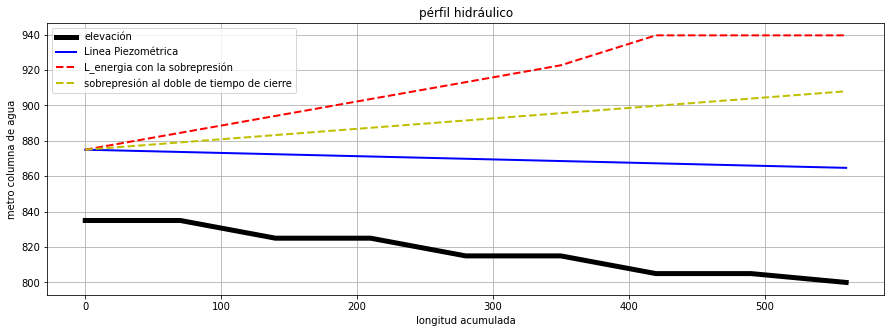

In [20]:
t_valvula2=t_valvula*2
#Determinación del tipo de cierre (rápido o lento )
if t_valvula2>t_onda:
    cierre=0
    delta_h2= 2*distancia*vel/9.81/t_valvula #formula de sobrepresión MICHAUD
else:
    cierre=1
    delta_h2=celeridad*vel/9.81  #formula de sopresión según Allieve
# Calculos de Longitudes Sobresión decreciente 
long_deltaH_decreciente2=celeridad*t_valvula2/2
long_deltaH_constante2=float(0.00)
if long_deltaH_decreciente2>distancia:
    long_deltaH_constante=float(0.00)
else:
    long_deltaH_constante2=distancia-long_deltaH_decreciente2
# calculo de la sobrepresión máxima segun michaud (dato teoríco)
df['L_Michaud2']=df['L_piezometrica']+2*df['long_acum']*vel/9.81/t_valvula2

# determinación de la sobrepresión esperada (linea piezométrica)
a=list(range(0,len(df)))
if distancia<long_deltaH_decreciente2:
    df["LP_deltaH2"]=df['L_Michaud2']
else:
    for x in a:
        long=df.loc[x,'long_acum']
        if long>long_deltaH_decreciente2:
            df.at[x,"LP_deltaH2"]=df.loc[0,'L_piezometrica']+(vel*celeridad/9.81)
        else:
            df.at[x,"LP_deltaH2"]=df.loc[x,'L_Michaud2']

df["P_tubo_Golpe2"]=df['LP_deltaH2']-df['L_piezometrica']
pmax2=df['P_tubo_Golpe2'].max()

print ("##############################")
print ("Para un tiempo de cierre de "+str(t_valvula)+" s, la máxima sobrepresión en el tubo es de "+str(pmax1.round(2))+" mca")
print ("Para un tiempo de cierre de "+str(t_valvula2)+" s, la máxima sobrepresión en el tubo es de "+str(pmax2.round(2))+" mca")
print ("##############################")

#grafico del perfil hidráulico 

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.plot(df["long_acum"],df["elevacion"], color='k',linewidth=5,
                label='elevación')
rects2 = ax.plot(df["long_acum"],df["L_piezometrica"], color='b',linewidth=2,
                label='Linea Piezométrica')
rects3 = ax.plot(df["long_acum"],df["LP_deltaH"], color='r',linewidth=2,linestyle='--',
                label='L_energia con la sobrepresión') 
rects4 = ax.plot(df["long_acum"],df["LP_deltaH2"], color='y',linewidth=2,linestyle='--',
                label='sobrepresión al doble de tiempo de cierre') 
   
ax.set_xlabel('longitud acumulada')
ax.set_ylabel('metro columna de agua')
ax.set_title('pérfil hidráulico')
ax.grid(True)
ax.legend()
plt.show()